In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import queue
%matplotlib inline
from os import path

# import data
# import config
# import process

In [8]:
class DataSet(object):
    headers = ['center', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']

    def __init__(self, log_img_paths):
        """
        log_img_paths: a list of tuple (path_to_log.csv, path_to_IMG_folder)
        """
        logs = []
        for log_path, image_folder in log_img_paths:
            #image_folder = path.abspath(image_folder)
            log = pd.read_csv(log_path, header=None, names=self.headers)
            for col in ["center", "left", "right"]:
                log[col] = log[col].str.rsplit("/", n=1).str[-1].apply(lambda p: path.join(image_folder, p))

            logs.append(log)
        
        self.log = pd.concat(logs, axis=0, ignore_index=True)
        self.index = 0

#     def preprocess(self):
#         """preprocess dataset"""
#         self.remove_noise()
#         # using mirror translation makes training for more epochs possible
#         # self.mirror()
#         self.shuffle()
#         return self


#     def remove_noise(self):
#         N = self.log.shape[0]

#         speeds = self.log.speed.convert_objects(convert_numeric=True)        
#         # focus on speed >= 20 
#         self.log = self.log[ speeds >= 20.]
#         print("%d records have been removed due to speed <= 20" % (N- self.log.shape[0]))

#         throttles = self.log.throttle.convert_objects(convert_numeric=True)        
#         # focus on throttles >= 0.25 
#         self.log = self.log[ throttles >= .25]
#         print("%d records have been removed due to throttles < 0.25" % (N- self.log.shape[0]))

#         return self

#     def split(self, test_size):
#         itrain, itest = train_test_split(np.arange(self.log.shape[0]), test_size=test_size)
#         train_log = self.log.iloc[itrain]
#         test_log = self.log.iloc[itest]
#         train_dataset = self.copy_constructor(train_log, 0)
#         test_dataset = self.copy_constructor(test_log, 0)
#         return (train_dataset, test_dataset)

#     def reset(self):
#         self.index = 0
#         return self             


#     def shuffle(self):
#         self.log = self.log.reindex(np.random.permutation(self.log.index))
#         return self

#     def copy_constructor(self, log, index):
#         rhs = copy.deepcopy(self)
#         rhs.log = log
#         rhs.index = index
#         return rhs


#     def make_batch_generator(self, batch_size, col_grps, process_fns = None, task ='train' ):
#         """
#         col_grps = list of grouped cols, each grouped cols are a list/string itself, e.g.
#         col_grps = [xcols, ycols, wtcols]. Data from multiple cols in a group are stacked
#         process_fns = a dict of {col: fn}, where fn is used to process col. The fn must take a single 
#         element (not a batch), e.g, an image as input. 
#         """
#         process_fns = process_fns or {}
#         def _generator(stream):

#             batch_items = []
#             for i, row in enumerate(stream):                
#                 item = []
#                 fn = process_fns[task]  

#                 keep_pr = 0  
#                 count = 0 
#                 while keep_pr == 0:
#                     image, steer = fn(row) 
#                     pr_unif = np.random
#                     if abs(steer)<.15:
#                         pr_val = np.random.uniform()
#                         if pr_val>config.pr_threshold:
#                             keep_pr = 1
#                         keep_pr = 1 if count > 100 else 0
#                         count +=1
#                     else:
#                         keep_pr = 1  


#                 item.append(image)
#                 item.append(steer)                
#                 batch_items.append(item)
#                 if len(batch_items) >= batch_size:
#                     current_batch = batch_items[:batch_size]
#                     yield tuple(map(np.asarray, zip(*current_batch)))
#                     batch_items = batch_items[batch_size:]

#         return _generator(self)                    


    def size(self):
        return self.log.shape[0]

    def __next__(self):
        self.index %= self.size()
        self.index += 1
        return self.log.iloc[self.index-1]

    def __iter__(self):
        return self

    def next(self):
        return __next__(self)

In [9]:
# log_path=os.getcwd()+'/data/driving_log.csv'
# # img_path=os.getcwd()+'/data/IMG/*.jpg'

# ####read data#########
# ######################

# from numpy import genfromtxt
# def decode_filename(filename):
# 	return os.getcwd()+'/data/'+filename.decode("utf-8").strip()

# files = genfromtxt(log_path,delimiter=',',dtype="|S50, |S50, |S50, float, float, float, float")
# files=files[1:]
# files = np.array(files)
# src_img_names=[]
# src_steering_angles=[]


# for line in files:
# 	steering_angle = line[3]
# 	center_name= decode_filename(line[0])
# 	left= decode_filename(line[1])
# 	right= decode_filename(line[2])
# 	src_img_names.append(center_name)
# 	src_steering_angles.append(steering_angle)
# 	src_img_names.append(left)
# 	src_steering_angles.append(steering_angle+CAMERA_OFFSET)
# 	src_img_names.append(right)
# 	src_steering_angles.append(steering_angle-CAMERA_OFFSET)

# #shuffle data to avoid overfitting
# from sklearn.utils import shuffle
# src_img_names,src_steering_angles= shuffle(src_img_names,src_steering_angles)
# #reformat list as np array
# src_img_names=np.array(src_img_names)
# src_steering_angles=np.array(src_steering_angles)

# print("data size:",src_img_names.shape[0])
dataset = DataSet([("../data/driving_log.csv", "data/IMG/")])
print(dataset.size())

8037


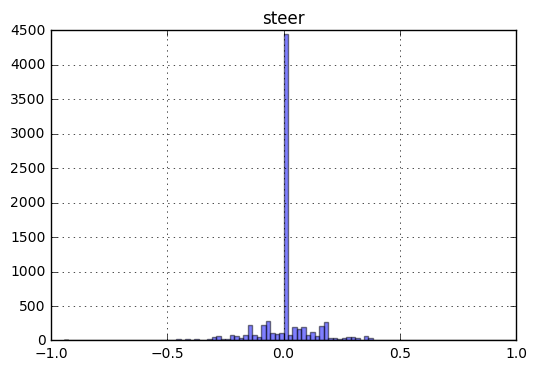

In [17]:
# import config
train_data = [
        # data of track1 from udacity
        ("../data/driving_log.csv", "data/IMG/")
]
log = pd.read_csv(train_data[0][0])
log.columns = ['center', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']

plt.figure();
log.hist(column='steer',bins=101,alpha=0.5)
plt.show()

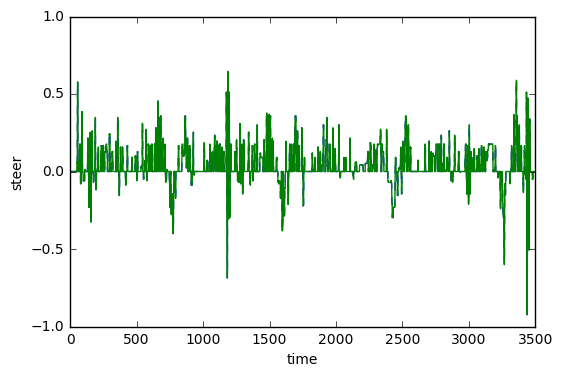

In [18]:
len_plt = 3500

steers_input= np.array(log.steer,dtype=np.float32)

t_s = np.arange(len(steers_input))
x_s = np.array(log.steer)
y_s = steers_input

plt.plot(t_s[0:len_plt],x_s[0:len_plt],'--',t_s[0:len_plt],y_s[0:len_plt]);
plt.xlabel('time')
plt.ylabel('steer')
plt.ylim(-1,1);

log['steer'] = pd.Series(steers_input, index=log.steer.index)

In [19]:
i = np.random.randint(dataset.size())
print(i)

row = dataset.log.iloc[[i]].reset_index()
queen_command = queue.Queue()

path_pre = '../'
imagefile_path_c = path_pre + row.center[0]
imagefile_path_l = path_pre + row.left[0]
imagefile_path_r = path_pre + row.right[0]
steer = float(row.steer[0])

commands = {'shift': 'shift', 'resize': 'resize', 'flip': 'flip','none': 'none','brightness' : 'brightness'}

6837


In [26]:
def _shift_image(image,steer,lane_id):    
    # Translation
    shift_range = 150
    steer = float(steer)
    rows,cols = image.shape[:2]
    trans_range = shift_range
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    # steer_ang = steer + tr_x/trans_range*2*.3	
    tr_y = 10*np.random.uniform()-10/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))

    return image_tr,steer_ang,tr_x

def _brightness_image(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def _crop_and_resize_image(image):
    # Preprocessing image files
    col,row,ch = config.image_size
    cropped_image = image[55:135, :, :]    
    shape = cropped_image.shape
    # note: numpy arrays are (row, col)!
    image = cropped_image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(col,row), interpolation=cv2.INTER_AREA)    
    return image     

def _flip_image(image,steer):
	steer = float(steer)
	prob_f = np.random.random()
	if prob_f > 0.5:
		# # flip the image and reverse the steering angle
		steer_out = -1*steer
		image_out =  cv2.flip(image, 1)
	else:
		image_out, steer_out = image, steer
	return image_out, steer_out

def plot_images(images,steers,titles,deg = 0):
    plt.subplot(1,3,1)
    plt.imshow(images[0]);
    plt.axis('on')    
    if deg==0:
        plt.title(titles[0] + ' ' +'steer:'+ str(np.round(steers[0],2) ) );        
    else:
        plt.title('Steer:'+ str((np.round((steer+.1)*180/np.pi,2) )))
    plt.subplot(1,3,2)
    plt.imshow(images[1]);
    plt.axis('on')        
    if deg==0:
        plt.title('Steer:'+ str(np.round(steers[1],2) ));
        plt.title(titles[1] + ' ' +'steer:'+ str(np.round(steers[1],2) ) );                
    else:
        plt.title('Steer:'+ str(np.round(steer*180/np.pi,2) ));
    plt.subplot(1,3,3)
    plt.imshow(images[2]);    
    plt.axis('on')        
    if deg==0:
        plt.title(titles[2] + ' ' +'steer:'+ str(np.round(steers[2],2) ) );        
    else:
        plt.title('Steer:'+ str((np.round((steer-.1)*180/np.pi,2) )))     

def process_images(image_path,steer,lane_id, command_q):

    image = cv2.imread(image_path)   
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 

    steer = float(steer)

    while command_q.qsize() > 0:
        command = command_q.get()
        
        if  command == commands['none']:
            command_q.empty()    

        if  command == commands['shift']:
            image,steer,tr_x = _shift_image(image,steer,lane_id)

        if  command == commands['resize']:
            image = _crop_and_resize_image(image)

        if  command == commands['flip']:
            image,steer = _flip_image(image,steer)

        if  command == commands['brightness']:
            image = _brightness_image(image)

    return image,steer

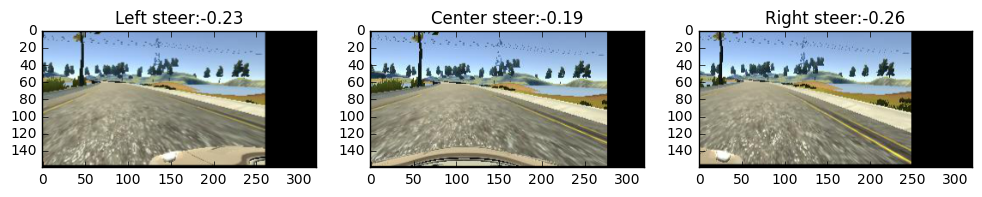

In [28]:

# queen_command.put(commands['none'])
queen_command.put(commands['shift'])
# queen_command.put(commands['brightness'])
# queen_command.put(commands['resize'])
# queen_command.put(commands['flip'])
image_c,steer_c = process_images(imagefile_path_c,steer,'center', queen_command)

# queen_command.put(commands['none'])
queen_command.put(commands['shift'])
# queen_command.put(commands['brightness'])
# queen_command.put(commands['resize'])
# queen_command.put(commands['flip'])
image_l,steer_l = process_images(imagefile_path_l,steer,'left', queen_command)

# queen_command.put(commands['none'])
queen_command.put(commands['shift'])
# queen_command.put(commands['brightness'])
# queen_command.put(commands['resize'])
# queen_command.put(commands['flip'])
image_r,steer_r = process_images(imagefile_path_r,steer,'right', queen_command)

image_arr = [image_l,image_c,image_r] 
# steer_arr = [steer_l,steer_c,steer_r]
steer_arr = np.array([steer_l,steer_c,steer_r], dtype='float32')
title_arr = ['Left','Center','Right']
         
plt.rcParams['figure.figsize'] = (12, 6)
plot_images(image_arr,steer_arr,title_arr)
plt.show()

In [35]:
from PIL import Image
from PIL import ImageEnhance
def random_shear(image, steering, shear_range):
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    #    print('dx',dx)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering += dsteering
    return image, steering

# def random_roll(image, steering_angle, start_range, end_range):
#     random_roll = np.random.randint(start_range, end_range)
#     image = np.roll(image, random_roll, axis=1)
#     return image, steering_angle + random_roll / 400

def augment_brightness_camera_images(image):
    enhancer = ImageEnhance.Brightness(Image.fromarray(image))
    img_enhanced = enhancer.enhance(0.5)
    return np.array(img_enhanced)

In [36]:
def augment_image(image, steering_angle):
    image = augment_brightness_camera_images(image)
    image, steering_angle = random_shear(image, steering_angle, 100)
    return image, steering_angle

In [38]:
def plot_2images(images,steers,titles,deg = 0):
    plt.subplot(1,2,1)
    plt.imshow(images[0]);
    plt.axis('on')    
    if deg==0:
        plt.title(titles[0] + ' ' +'steer:'+ str(np.round(steers[0],2) ) );        
    else:
        plt.title('Steer:'+ str((np.round((steer+.1)*180/np.pi,2) )))
    plt.subplot(1,2,2)
    plt.imshow(images[1]);
    plt.axis('on')        
    if deg==0:
        plt.title('Steer:'+ str(np.round(steers[1],2) ));
        plt.title(titles[1] + ' ' +'steer:'+ str(np.round(steers[1],2) ) );                
    else:
        plt.title('Steer:'+ str(np.round(steer*180/np.pi,2) ));
    

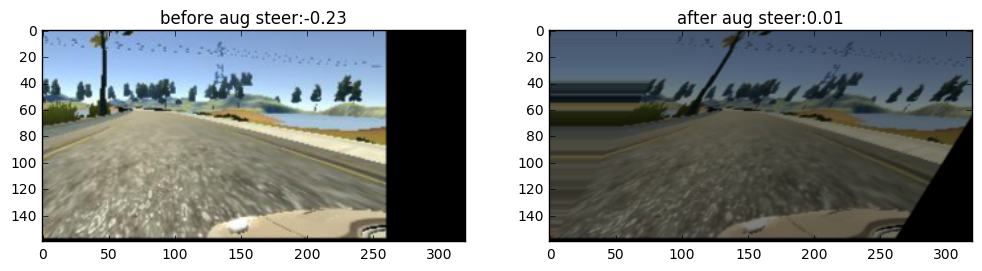

In [40]:
augment, ster = augment_image(image_l,steer_l)
arr = [image_l, augment]
st_arr = np.array([steer_l,ster], dtype='float32')
ti_arr = ['before aug','after aug']

plt.rcParams['figure.figsize'] = (12, 6)
plot_2images(arr,st_arr,ti_arr)
plt.show()